**Outline**

1.   Import the necessary libraries
2.   Define Identity block and Projection block
3.   Build the model
4.   Compile and train it




## 1 - Import the necessary libraries

In [12]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation, BatchNormalization, ReLU, AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow_hub as hub
import numpy as np
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import json
drive.mount("/content/drive")
os.chdir("/content/drive/MyDrive/archive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!ls

checkpoint-folder  MLProject.ipynb  ResNet.ipynb  test	train


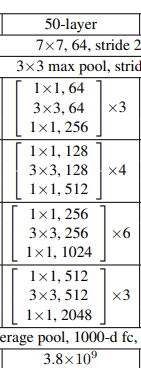

As we can see from this screenshot, every time the block is built with the following pattern: the third layer has 4 times the number of filters of the previos layers.

## 2 - Define Identity and Projection block

In this identity block, the variable _x_ represents the input tensor. Namely, it is the input tensor that we want to process through the identity block.

In this function, the returned **x** represents the combined result of processing the initial input tensor through the identity block's convolutional and normalization layers and adding it back to the original input tensor.

In [9]:
def identity_block(input, filters):
  """
  In this function, the returned x will be the combination of the "processed"
  input tensor (i.e., the tensor that went through all the layers) and the
  initial input
  """

  # 1x1 convolutional layer
  x = Conv2D(filters=filters, kernel_size=(1,1))(input) # should we add the strides?
  x = BatchNormalization()(x)
  x = ReLU(x)

  # 3x3 convolutional layer
  x = Conv2D(filters=filters, kernel_size=(3,3), padding='same')(x)
  x = BatchNormalization()(x)
  x = ReLU()(x)

  # final 1x1 convolutional layer
  x = Conv2D(filters=4*filters, kernel_size=(1,1))(x)
  x = BatchNormalization()(x)

  # skip connection
  x = Add()([input, x])

  # ReLU activation function
  x = ReLu()(x)

  return x

The purpose of the projection block is to adapt the dimensions of the input tensor to match the dimensions of the output tensor so that they can be added together.

Here are the main components and steps involved in a projection block:

1) **Left Stream**: This stream operates on the input tensor and is responsible for performing the main convolutional and normalization operations.

2) **Right Stream (Shortcut)**: The right stream is responsible for adjusting the dimensions of the input tensor so that it matches the dimensions of the output tensor. It typically involves a 1x1 convolution layer with an appropriate stride to achieve the necessary downscaling or upscaling.

3) **Skip Connection**: Just like in identity blocks, a skip connection is used to add the processed left stream tensor to the adjusted right stream tensor.

4) **ReLU Activation**: After the addition of the tensors, a ReLU activation function is applied to the combined tensor.

*The key idea is that the right stream, which includes the 1x1 convolution, adjusts the dimensions of the input tensor so that it can be added to the left stream without causing dimension mismatches.*



In a projection block, the first 1x1 convolution typically has a stride of 2 to downsample the spatial dimensions, while the subsequent 3x3 convolution and the final 1x1 convolution usually have a stride of 1. This is to ensure that the spatial dimensions of the feature map are maintained until the final 1x1 convolution, which adjusts the number of filters.

In [10]:
def projection_block(input, filters, strides):

    """ left stream """
    # 1x1 convolutional layer
    x = Conv2D(filters=filters, kernel_size=(1,1), strides=(2,2))(x) # strides=(2,2) for downsampling
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # 3x3 convolutional layers
    x = Conv2D(filters=filters, kernel_size=(3,3), strides=(1,1), padding='same')(x) # 'same' padding to maintain the spatial dimensions
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # 1x1 final convolutional layer
    x = Conv2D(filters=4*filters, kernel_size=(1,1), strides=(1,1))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    """ right stream """
    # 1x1 convolutional layer
    shortcut = Conv2D(filters=4*filters, kernel_size=(1,1), strides=(2,2))(input) # strides=(2,2) for downsampling
    shortcut = BatchNormalization()(shortcut)

    """ combine left and right streams """
    # skip connection
    x = Add()([shortcut, x])
    x = ReLU()(x)

    return(x)

## 3 - Build the model, following the ResNet50 architecture

In [13]:
def build_resnet_model():

  # first layer
  x = Conv2D(filters=64, kernel_size=(7,7), strides=(2,2))
  x = BatchNormalization()(x)
  x = ReLU()(x)
  x = MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same')(x) # not sure about the padding here

  # first block of 3
  for _ in range(2):
    x = identity_block(input=x, filters=64)

  # second block of 4
  for _ in range(3):
    x = projection_block(input = x, filters = 128, strides=2)

  # third block of 6
  for _ in range(5):
    x = projection_block(input = x, filters = 256, strides=2)

  # fourth - and last - block of 3
  for _ in range(2):
    x = projection_block(input = x, filters = 512, strides=2)

  # final step
  x = AveragePooling2D()(x)
  x = Dense(1, activation='sigmoid')(x)

  # model
  ResNet50 = Model(inputs=input, output=x)
  return ResNet50

--------------------------------------------------------------------------------

## **APPENDIX**

**Question 1: why do we write the (x) outside the parenthesis?**

The syntax of using a separated parenthesis to apply a layer to a tensor in Keras and TensorFlow functional API has a specific purpose and advantage in terms of flexibility and modularity in building complex neural network architectures.

Here's why this syntax is used:

1. **Separation of Concerns:** By using a separate set of parentheses, you clearly separate the definition of the layer from its application to the input tensor. This makes the code more readable and easier to understand, especially in complex models.

2. **Reusability:** Separating the layer creation from its application allows you to reuse the same layer in multiple parts of the model. You can create a layer once and apply it to different input tensors as needed.

3. **Dynamic Graph Construction:** Keras and TensorFlow allow you to construct models with dynamic architectures, where the shape of the input tensor may vary. Using this syntax allows you to apply a layer to a tensor without needing to know the shape of the tensor when you define the layer.

4. **Functional API Flexibility:** The functional API in Keras is designed to offer flexibility in creating custom models with complex architectures. The separation of the layer definition from its application gives you control over the flow of data through the network.

In summary, the syntax of using a separate set of parentheses to apply a layer to a tensor is a design choice that provides modularity, reusability, and flexibility when building complex neural network models. It helps make the code more readable and easier to work with, especially in scenarios where you have multiple layers applied to different input tensors within a single model.

--------------------------------------------------------------------------------
**Question 2:  focusing on those block (three times etc, four times etc, six times etc...) how can I know which one of them is identity block or projection block?**

In a ResNet architecture like ResNet-50, the different types of blocks are organized as follows:

1. **Conv1 Layer (Initial Convolution):**
   - Convolutional layer with a kernel size of 7x7, 64 filters, and a stride of 2.
   - This is followed by a 3x3 max-pooling layer with a stride of 2.

2. **Block 1: Identity Block (Repeated Three Times):**
   - Each block in this stage consists of three identity blocks.
   - Identity Block: These are the basic building blocks of ResNets, and they do not change the spatial dimensions of the input feature map. They consist of a series of 1x1, 3x3, and 1x1 convolutional layers.
   - Filters: The number of filters increases with each block, but each identity block within the block has the same number of filters.

3. **Block 2: Projection Block (Repeated Four Times):**
   - Each block in this stage consists of four projection blocks.
   - Projection Block: These blocks use 1x1 convolutional layers to downsample the input feature map's spatial dimensions. They include 1x1, 3x3, and 1x1 convolutional layers.
   - Filters: The number of filters increases with each block, and projection blocks are used to downsample the spatial dimensions.

4. **Block 3: Projection Block (Repeated Six Times):**
   - Each block in this stage consists of six projection blocks.
   - Projection Block: Similar to Block 2, these blocks downsample the feature map's spatial dimensions.

5. **Block 4: Projection Block (Repeated Three Times):**
   - Each block in this stage consists of three projection blocks.
   - Projection Block: These blocks downsample the feature map's spatial dimensions.

So, in ResNet-50, you can identify the identity blocks as the ones within Block 1 (repeated three times), and the projection blocks as the ones within Blocks 2, 3, and 4, based on their role in changing the spatial dimensions of the feature maps. Identity blocks preserve spatial dimensions, while projection blocks adjust them. This is a common pattern in ResNet architectures to enable efficient training of very deep networks.